### Assignment 02

Start by importing all required libraries.

In [80]:
import cv2
import numpy as np

from scipy.optimize import minimize
from scipy import linalg

import matplotlib.pyplot as plt
import tikzplotlib

ImportError: cannot import name 'common_texification' from 'matplotlib.backends.backend_pgf' (d:\UoM\Semester 5\EN3160 - Image Processing and Machine Vision\Assignment 02\.venv\Lib\site-packages\matplotlib\backends\backend_pgf.py)

#### Question 01

We start by importing the required image in grayscale.

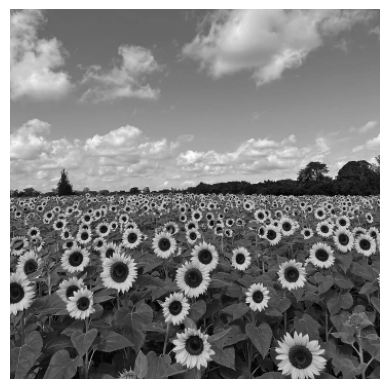

In [ ]:
im = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

We will look for blobs using a Laplacian of Gaussian (LoG) kernel.

A 2D (continuous) Gaussian with zero-mean and variance $\sigma^2$ is given by
$$
G(x, y) = \dfrac{1}{2\pi\sigma^2} \exp\left(-\dfrac{x^2+y^2}{2\sigma^2}\right),
$$
and its Laplacian is given by
$$
L(x, y) = \nabla^2 \, G(x, y) = \left[ \dfrac{x^2 + y^2 - 2\sigma^2}{2\pi\sigma^6}\right] \exp\left(-\dfrac{x^2+y^2}{2\sigma^2}\right).
$$

We now implement the LoG kernel.

In [ ]:
def LoG(sigma, k):
    '''
        Generate a k x k Laplacian of Gaussian kernel with standard deviation sigma.

        k is expected to be odd.
    '''
    
    k = (k - 1) // 2

    X, Y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))

    R2 = X**2 + Y**2

    log = ((R2 - 2*sigma**2) / (2*np.pi*sigma**6)) * np.exp(-R2 / (2*sigma**2))

    return log

Consider a (continuous) image of a perfect circle of radius $R$, given by
$$
I(x, y) =
\begin{cases}
1, & x^2 + y^2 < R^2, \\
0, & \text{otherwise}.
\end{cases}
$$

It is easy to see (due to radial symmetry) that the response of the LoG kernel to such an image is
$$
2\pi \int_0^R L(x, 0) \, dx,
$$
and that this response is maximum when 
$$
\dfrac{\text{d}}{\text{d}R} \int_0^R L(x, 0) \, dx = L(R, 0) = 0,
$$
which occurs precisely when
$$
R=\sigma\sqrt{2}.
$$

Hence, the kernel's maximum response for a circle occurs when it has radius $\sigma\sqrt{2}$; and so we conclude that a LoG kernel with parameter $\sigma$ acts to detect blobs of "radius" $\sigma\sqrt{2}$.

Below, we implement the code to run a LoG kernel over an image with some specified $\sigma$.

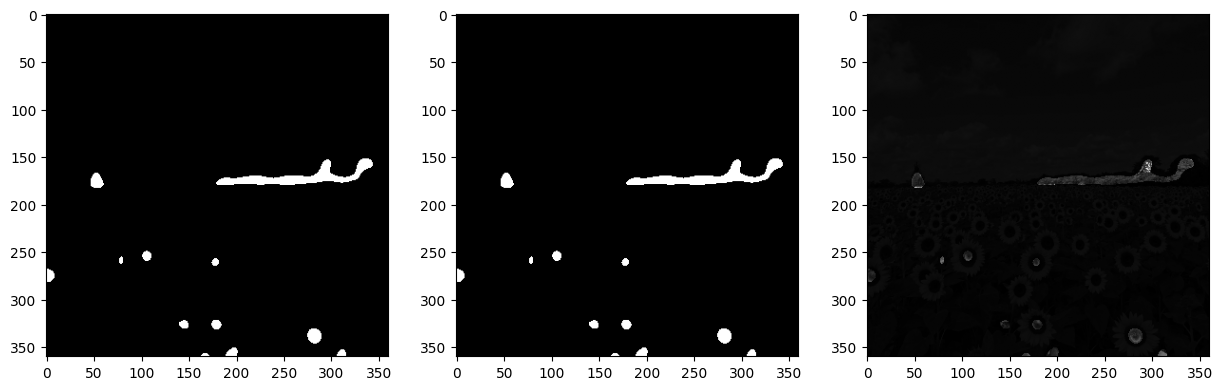

In [ ]:
def detect_blobs(im, sigma, size, thresh):
    '''
    docstring
    '''
    
    log = LoG(sigma, size)

    response = cv2.filter2D(im, -1, log)

    max = np.max(response)

    detected_blobs = response > 0.98*max

    _, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(response, cmap='gray')
    ax[1].imshow(detected_blobs, cmap='gray')
    ax[2].imshow(im*(detected_blobs + 0.05), cmap='gray')

detect_blobs(im, 8, 8*6 + 1, 1)

#### Question 02

We start by generating a set of noisy points belonging to a line and a circle, using the code given in the assignment:

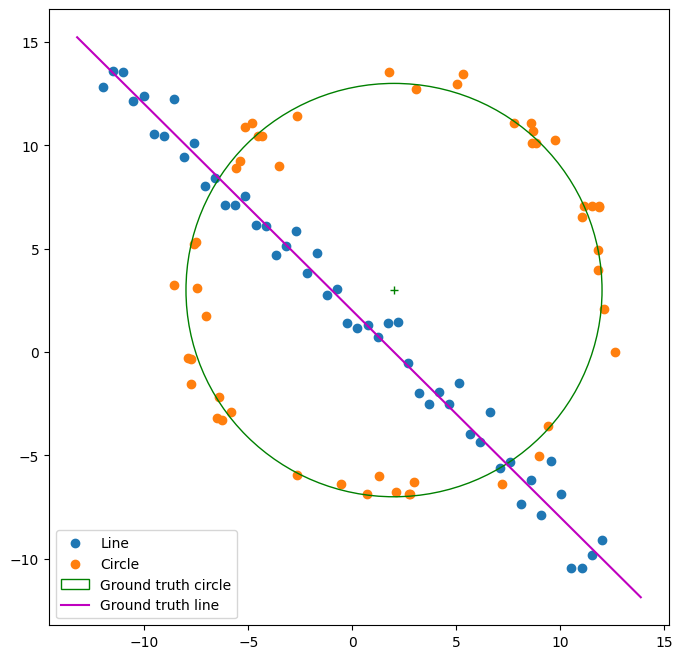

In [131]:
# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3 # Center
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line)) # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')

ax.add_patch(circle_gt)
ax.plot([x0_gt], [y0_gt], '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])

y_ = m*x_ + b

plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

plt.show()

The basic principle behind RANSAC is as follows:
- sample $N$ points randomly
- compute the parameters for the model using the sampled points
- count the number of inliers based on the model described by the above parameters and some specified threshold
- repeat $M$ times, so that we are at least $100\times p\%$ confident that we found at least one set of inliers
- report the parameters giving the most inliers as the best parameter estimates

We implement the above steps in the following function.

In [149]:
def RANSAC(data, num_samples, params_from_samples, model, inlier_thresh, iterations):
    '''
    docstring

    data is an array of tuples, each of num_samples elements
    '''
    max_inlier_count = 0
    best_samples = None
    best_inliers = None
    best_params = None

    for _ in range(iterations):
        # Generate num_samples random integers between 0 and len(data), use these as indices to extract num_samples random samples from the data 
        sample_indices = np.random.randint(0, len(data), num_samples)
        samples = data[sample_indices]

        # Compute the model parameters using the above sampled points
        params = params_from_samples(samples)

        # Count the number of inliers based on the model described by the above parameters, and the specified threshold
        inliers = data[np.abs(model(params, data)) < inlier_thresh]

        # Keep track of which parameters produced the most inliers
        if (len(inliers) > max_inlier_count):
            max_inlier_count = len(inliers)
            best_samples = samples
            best_inliers = inliers
            best_params = params

    return best_samples, best_inliers, best_params

We will parameterize a straight line by $$x\cos\theta + y\sin\theta = d,$$ in terms of the parameters $\theta$ and $d$. Then, given two points $\left(x_1, y_1\right)$ and $\left(x_2, y_2\right)$ known to lie on the line, it can be shown that
$$
\theta = \arctan 2\left(x_2 - x_1, y_1 - y_2\right) \quad \text{and} \quad d = x_1 \cos\theta + y_1 \sin\theta.
$$
Further, given any point $(x, y)$, and a choice of parameters $\theta$ and $d$, we will consider the quantity $$\left|x\cos\theta + y\sin\theta - d\right|,$$ which is precisely the perpendicular distance from the point to the line, as a measure of how well the model describes $(x, y)$. If it is smaller than some threshold, we will consider the point to be an inlier, and an outlier otherwise.

Functions to compute these quantities are implemented below for a straight line.

In [133]:
def line_params_from_samples(samples):
    '''
        for a line we expect two samples
    '''

    x1, y1 = samples[0]
    x2, y2 = samples[1]

    theta = np.atan2((x2 - x1), (y1 - y2))
    d = x1*np.cos(theta) + y1*np.sin(theta)

    return (theta, d)

def line_model(params, data):
    theta, d = params
    x, y = data[:, 0], data[:, 1]

    return x*np.cos(theta) + y*np.sin(theta) - d

We will parameterize a circle by
$$
(x-h)^2 + (y-k)^2 = r^2,
$$
where $h$, $k$, $r$ are parameters.

This time, given three points $\left(x_1, y_1\right)$, $\left(x_2, y_2\right)$ and $\left(x_3, y_3\right)$ that lie on the line, it can be shown that
$$
h = \dfrac{B_2C_1 - B_1C_2}{A_1B_2 - A_2B_1}, \quad \text{and} \quad k = \dfrac{A_2C_1 - A_1C_2}{A_2B_1 - A_1B_2},
$$
where $A_1 = 2x_2-2x_1$, $A_2 = 2x_3 - 2x_1$, $B_1 = 2y_2 - 2y_1$, $B_2 = 2y_3 - 2y_1$, $C_1 = x_2^2 - x_1^2 + y_2^2 - y_1^2$ and $C_2 = x_3^2 - x_1^2 + y_3^2 - y_1^2$. Further, for these values of $h$ and $k$, we have
$$
r = \sqrt{\left(x_1 - h\right)^2 + \left(y_1 - k\right)^2}.
$$

Given an arbitrary point $(x, y)$ and the parameters $h$, $k$ and $r$, we will consider $$\left|r - \sqrt{\left(x - h\right)^2 + \left(y - k\right)^2}\right|,$$ the "radial error", as a measure of how well the model describes the point.

We implement the code to compute these quantities in the following function.

In [134]:
def circle_params_from_samples(samples):
    '''
        for a line we expect 3 samples
    '''

    x1, y1 = samples[0]
    x2, y2 = samples[1]
    x3, y3 = samples[2]

    A1 = 2*(x2 - x1)
    A2 = 2*(x3 - x1)
    B1 = 2*(y2 - y1)
    B2 = 2*(y3 - y1)
    C1 = x2**2 - x1**2 + y2**2 - y1**2
    C2 = x3**2 - x1**2 + y3**2 - y1**2

    h = (B2*C1 - B1*C2) / (A1*B2 - A2*B1)
    k = (A2*C1 - A1*C2) / (A2*B1 - A1*B2)
    r = np.sqrt((x1 - h)**2 + (y1 - k)**2)

    return (h, k, r)

def circle_model(params, data):
    h, k, r = params
    x, y = data[:, 0], data[:, 1]

    return r - np.sqrt((x - h)**2 + (y - k)**2)

If it is known/assumed that the fraction of inliers in the data is $r$, the probability that the $N$ points sampled are not all inliers is $1-r^N$. The probability that this is the case in all $M$ repetitions is $\left(1 - r^N\right)^M$, and hence the probability that at we pick all inliers in at least one repetition is $1 - \left(1 - r^N\right)^M$.

We would like to have
$$
1 - \left(1 - r^N\right)^M > p,
$$
or equivalently,
$$
M > \dfrac{\ln\left(1 - p\right)}{\ln\left(1 - r^N\right)}.
$$

In our case, $r=0.5$ in both cases of the line and the circle. For $p=0.99$, then, we require in the case of the line ($N=2$) that
$$
M > \dfrac{\ln 0.01}{\ln\left(1 - 0.5^2\right)} > 16,
$$
and in the case of the circle ($N=3$) that
$$
M > \dfrac{\ln 0.01}{\ln\left(1 - 0.5^3\right)} > 34,
$$
if we do not remove the points chosen for the line when sampling points for the circle.

For better results in both cases, we will set $M = 1000$.

We then run RANSAC as described to find the best parameter estimates for the line and the circle.

In [ ]:
line_best_samples, line_best_inliers, (theta_0, d_0) = RANSAC(X, 2, line_params_from_samples, line_model, 1, 1000)



print (theta_0*180/np.pi, d_0)

-133.63899620043958 -1.7150171783917276
